In [45]:
import pandas as pd
import matplotlib
from matplotlib import pylab as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import pylab as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from  sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost

In [13]:
df2 = pd.read_csv('../data/df_pre_splitting.csv')

In [15]:
df2['Cohort'] = df2['Cohort'].astype(str)

In [16]:
# wrote custom splitting function due to issues with getting sklearn to split based on year
def ts_train_test_spl(data):
    """Splits by year and transforms data for time series."""
    years = []
    d = {}
    for year in sorted(data['Cohort'].unique())[1:]:
               
        train = data[data['Cohort'] <= str(int(year) -1)]
        y_train = train[['y']]
        val = data[data['Cohort'] == year]
        y_val = val[['y']]
        train = train.drop('y', axis=1)
        val = val.drop('y', axis=1)
 

        onehot_ftrs = ['BORO']
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
        enc.fit(train[onehot_ftrs])
        
        onehot_train = enc.transform(train[onehot_ftrs])
        onehot_val = enc.transform(val[onehot_ftrs])
        onehot_train = pd.DataFrame(onehot_train)
        onehot_val = pd.DataFrame(onehot_val)

        train = train.reset_index(drop=True)
        val = val.reset_index(drop=True)
        
        train2 = pd.concat([pd.DataFrame(train), pd.DataFrame(onehot_train)],ignore_index=True, axis = 1)
        train2.columns = list(train.columns) + list(enc.get_feature_names(onehot_ftrs))
        val2 = pd.concat([pd.DataFrame(val), pd.DataFrame(onehot_val)],ignore_index=True, axis = 1)
        val2.columns = list(val.columns) + list(enc.get_feature_names(onehot_ftrs))
        
        std_ftrs = ['Cohort', 'Total Cohort', 'Total Grads - n',
       'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'Income']
        
        std_target = ['y']
        
        scaler = StandardScaler()
        train_t = scaler.fit_transform(train2[std_ftrs])
        val_t = scaler.transform(val2[std_ftrs])
        
        df_train = pd.concat([train2[['BORO_K', 'BORO_M', 'BORO_Q', 'BORO_R', 'BORO_X']], pd.DataFrame(train_t)],ignore_index=True, axis = 1)
        df_train.columns = ['BORO_K', 'BORO_M', 'BORO_Q', 'BORO_R', 'BORO_X'] + std_ftrs
        
        df_val = pd.concat([val2[['BORO_K', 'BORO_M', 'BORO_Q', 'BORO_R', 'BORO_X']], pd.DataFrame(val_t)],ignore_index=True, axis = 1)
        df_val.columns = ['BORO_K', 'BORO_M', 'BORO_Q', 'BORO_R', 'BORO_X'] + std_ftrs
        
        d[year] = [df_train, y_train, df_val, y_val] 
    return d
dictionary = ts_train_test_spl(df2)

In [47]:
def baseline(d):
    """computes baseline for each split based on a baseline model which predicts the mean"""
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        
        mean = np.mean(d[date][1])
        print('mean: ', mean)

        y_train_pred = [mean for i in range(len(d[date][1]))]
        y_test_pred = [mean for i in range(len(d[str(int(date)+1)][3]))]

        train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
        train_r2 = r2_score(d[date][1],y_train_pred)

        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred, squared = False)
        
        print('   train RMSE:',(train_rmse))
        print('   test RMSE:',(test_rmse))
baseline(dictionary)

2002
mean:  y    55.542056
dtype: float64
   train RMSE: 21.155499218274798
   test RMSE: 22.29433412512326
2003
mean:  y    56.626991
dtype: float64
   train RMSE: 21.749476176581215
   test RMSE: 21.77536079177835
2004
mean:  y    58.252276
dtype: float64
   train RMSE: 21.805151202373782
   test RMSE: 22.379908368283523


In [29]:
def reg_fit(d):
    dates = ['2002', '2003', '2004']
    linreg = LinearRegression(fit_intercept=True)
    for date in dates:
        linreg.fit(d[date][0], d[date][1])
        print(date)
    
        y_train_pred = linreg.predict(d[date][0])
        y_test_pred = linreg.predict(d[str(int(date)+1)][2])

        train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
        train_r2 = r2_score(d[date][1],y_train_pred)

        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred, squared = False)
        test_r2 = r2_score(d[str(int(date)+1)][3], y_test_pred)
        
        print('   train RMSE:',(train_rmse))
        #print('   train R2', train_r2)
        print('   test RMSE:',(test_rmse))
        #print('   test R2', test_r2)
reg_fit(dictionary)  

2002
   train RMSE: 7.682535479923393
   test RMSE: 11.012817331554686
2003
   train RMSE: 8.258432402175394
   test RMSE: 13.536183328200346
2004
   train RMSE: 8.745924836652728
   test RMSE: 11.218994724715033


2002


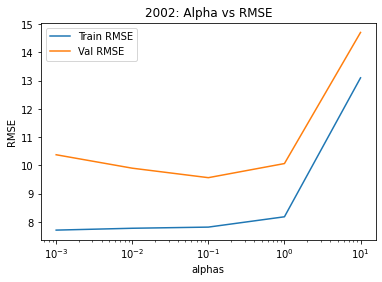

   min alpha: 0.1
   min val rmse: 9.569312894185625
test rmse:  9.88089208082889
2003


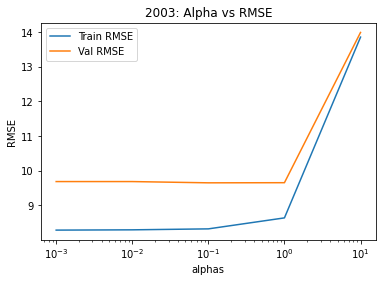

   min alpha: 0.1
   min val rmse: 9.651879354189212
test rmse:  10.78090743255249
2004


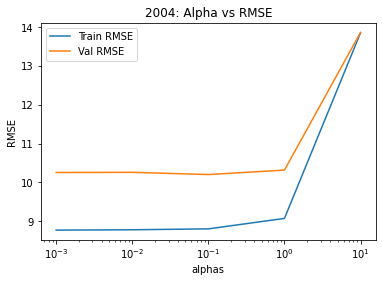

   min alpha: 0.1
   min val rmse: 10.203193970701296
test rmse:  9.481728599431532


In [28]:
def lasso_reg(d, alphas):
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 
        models_list = []
        for alpha in alphas:

            linreg = Lasso(alpha=alpha, max_iter=100000)
            linreg.fit(d[date][0], d[date][1])

            y_train_pred = linreg.predict(d[date][0])
            y_val_pred = linreg.predict(d[date][2])

            train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
            train_r2 = r2_score(d[date][1],y_train_pred)

            val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
            val_r2 = r2_score(d[date][3], y_val_pred)
            
            train_rmse_list.append(train_rmse)
            val_rmse_list.append(val_rmse)

        plt.plot(alphas, train_rmse_list, label='Train RMSE')
        plt.plot(alphas, val_rmse_list, label='Val RMSE')
        #plt.figure(figsize=(8,6))
        plt.legend()
        plt.xlabel('alphas')
        plt.ylabel('RMSE')
        plt.semilogx()
        plt.title(f"{date}: Alpha vs RMSE")
        plt.show()
        min_index = val_rmse_list.index(min(val_rmse_list))
        print(f"   min alpha: {alphas[min_index]}")
        print(f"   min val rmse: {val_rmse_list[min_index]}")

        linreg = Lasso(alpha=alphas[min_index], max_iter=100000000)
        linreg.fit(d[date][0], d[date][1])

        y_test_pred = linreg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)     

alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
lasso_reg(dictionary, alphas)

2002


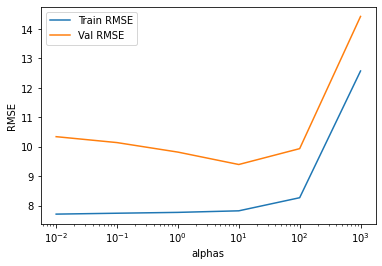

   min alpha: 10.0
   min val rmse: 9.400982308821066
test rmse:  9.869369494947962
2003


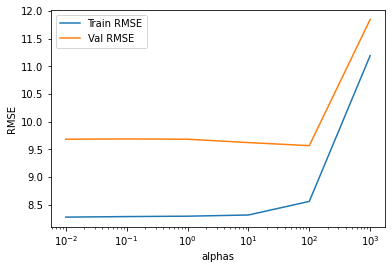

   min alpha: 100.0
   min val rmse: 9.567425008099086
test rmse:  10.502732551282861
2004


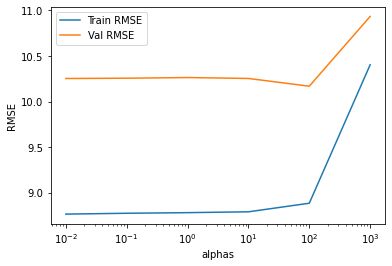

   min alpha: 100.0
   min val rmse: 10.168489930059852
test rmse:  9.562161639539573


In [31]:
def ridge_reg(d, alphas):
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 
        models_list = []
        for alpha in alphas:
            linreg = Ridge(alpha=alpha, max_iter=100000000)
            linreg.fit(d[date][0], d[date][1])

            y_train_pred = linreg.predict(d[date][0])
            y_val_pred = linreg.predict(d[date][2])

            train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
            train_r2 = r2_score(d[date][1],y_train_pred)

            val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
            val_r2 = r2_score(d[date][3], y_val_pred)
            
            train_rmse_list.append(train_rmse)
            val_rmse_list.append(val_rmse)

        plt.plot(alphas, train_rmse_list, label='Train RMSE')
        plt.plot(alphas, val_rmse_list, label='Val RMSE')
        plt.legend()
        plt.xlabel('alphas')
        plt.ylabel('RMSE')
        plt.semilogx()

        plt.show()
        min_index = val_rmse_list.index(min(val_rmse_list))
        print(f"   min alpha: {alphas[min_index]}")
        print(f"   min val rmse: {val_rmse_list[min_index]}")
        
        linreg = Ridge(alpha=alphas[min_index], max_iter=100000000)
        linreg.fit(d[date][0], d[date][1])

        y_test_pred = linreg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)
        
alphas = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
ridge_reg(dictionary, alphas)

In [34]:
def elastic_reg(d, alphas, l1_ratio):
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for alpha in alphas: 
            for ratio in l1_ratio:

                linreg = ElasticNet(alpha=alpha, l1_ratio= ratio, max_iter=1000000000)
                linreg.fit(d[date][0], d[date][1])

                y_train_pred = linreg.predict(d[date][0])
                y_val_pred = linreg.predict(d[date][2])

                train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                train_r2 = r2_score(d[date][1],y_train_pred)

                val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                val_r2 = r2_score(d[date][3], y_val_pred)

                train_rmse_list.append((train_rmse, alpha, ratio))
                val_rmse_list.append((val_rmse, alpha, ratio))

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min alpha: {min_score[1]}, min l1: {min_score[2]}")
        print(f"  min val rmse: {min_score[0]}")
        
        linreg = ElasticNet(alpha=min_score[1], l1_ratio= min_score[2], max_iter=1000000000)
        linreg.fit(d[date][0], d[date][1])

        y_test_pred = linreg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)

alphas, l1_ratio = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], np.linspace(1e-10, 1, 6)
elastic_reg(dictionary, alphas, l1_ratio)

2002
  min alpha: 0.1, min l1: 0.40000000006
  min val rmse: 9.375193130436292
test rmse:  9.85821202618577
2003
  min alpha: 0.1, min l1: 1e-10
  min val rmse: 9.546883129677113
test rmse:  10.556346991126956
2004
  min alpha: 0.1, min l1: 1e-10
  min val rmse: 10.185887599732284
test rmse:  9.539393219134636


In [36]:
def rf_reg(d, max_depth, max_features, rs):
    dates = ['2002', '2003', '2004']

    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for depth in max_depth: 
            for features in max_features:
                rf_reg = RandomForestRegressor(max_depth=depth, max_features=features, random_state=rs)

                rf_reg.fit(d[date][0], d[date][1].values.ravel())

                y_train_pred = rf_reg.predict(d[date][0])
                y_val_pred = rf_reg.predict(d[date][2])

                train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                train_r2 = r2_score(d[date][1],y_train_pred)

                val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                val_r2 = r2_score(d[date][3], y_val_pred)

                train_rmse_list.append((train_rmse, depth, features))
                val_rmse_list.append((val_rmse, depth, features))

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min max_depth: {min_score[1]}, min max_features: {min_score[2]}")
        print(f"  min val rmse: {min_score[0]}")
        
        rf_reg = RandomForestRegressor(max_depth=min_score[1], max_features=min_score[2], random_state=rs)
        rf_reg.fit(d[date][0], d[date][1].values.ravel())

        y_test_pred = rf_reg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)

max_depth = [k**2 for k in range(1,7)] 
max_features = [.5, .6, .7, .8, .9, 1] 
rs = 4       
        
rf_reg(dictionary, max_depth, max_features, rs)

2002
  min max_depth: 25, min max_features: 0.5
  min val rmse: 9.836275158391848
test rmse:  10.151002853252479
2003
  min max_depth: 16, min max_features: 0.5
  min val rmse: 9.729663954252464
test rmse:  10.756206234334087
2004
  min max_depth: 25, min max_features: 1
  min val rmse: 9.92207995714235
test rmse:  10.474382715946179


In [38]:
def svm_reg(d, gamma_vals, C_vals, kernels):
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for gamma in gamma_vals: 
            for C in C_vals:
                for kernel in kernels:
                    
                    svm_reg = SVR(kernel=kernel, gamma=gamma, C=C)

                    svm_reg.fit(d[date][0], d[date][1].values.ravel())

                    y_train_pred = svm_reg.predict(d[date][0])
                    y_val_pred = svm_reg.predict(d[date][2])

                    train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                    train_r2 = r2_score(d[date][1],y_train_pred)

                    val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                    val_r2 = r2_score(d[date][3], y_val_pred)

                    train_rmse_list.append((train_rmse, kernel, gamma, C))
                    val_rmse_list.append((val_rmse, kernel, gamma, C))

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min kernel: {min_score[1]}, min gamma: {min_score[2]}, min C: {min_score[3]}")
        print(f"  min val rmse: {min_score[0]}")
        
        svm_reg = SVR(kernel=min_score[1], gamma=min_score[2], C=min_score[3])
        
        svm_reg.fit(d[date][0], d[date][1].values.ravel())

        y_test_pred = svm_reg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_vals = [2**k for k in range(-15,-7)]
C_vals = [2**k for k in range(5,9)]     
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
        
svm_reg(dictionary, gamma_vals, C_vals, kernels)

2002
  min kernel: rbf, min gamma: 0.00048828125, min C: 256
  min val rmse: 9.422346522016774
test rmse:  9.931287403560146
2003
  min kernel: sigmoid, min gamma: 0.00048828125, min C: 256
  min val rmse: 9.43954554021671
test rmse:  10.442639335446241
2004
  min kernel: rbf, min gamma: 0.0001220703125, min C: 128
  min val rmse: 10.099305678840777
test rmse:  9.440684615695643


In [39]:
def param_graph_svm_reg(d, gamma_vals, C_vals):
    dates = ['2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for gamma in gamma_vals: 
            for C in C_vals:

                svm_reg = SVR(kernel='rbf', gamma=gamma, C=C)

                svm_reg.fit(d[date][0], d[date][1].values.ravel())

                y_train_pred = svm_reg.predict(d[date][0])
                y_val_pred = svm_reg.predict(d[date][2])

                train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                train_r2 = r2_score(d[date][1],y_train_pred)

                val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                val_r2 = r2_score(d[date][3], y_val_pred)

                train_rmse_list.append((train_rmse, gamma, C))
                val_rmse_list.append((val_rmse, gamma, C))
                

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min gamma: {min_score[1]}, min C: {min_score[2]}")
        print(f"  min val rmse: {min_score[0]}")

    return val_rmse_list, train_rmse_list

gamma_vals = [2**k for k in range(-14,-6)]
C_vals = [2**k for k in range(5,9)]     
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
        
val_params, train_params = param_graph_svm_reg(dictionary, gamma_vals, C_vals)

2004
  min gamma: 0.0001220703125, min C: 128
  min val rmse: 10.099305678840777


2004


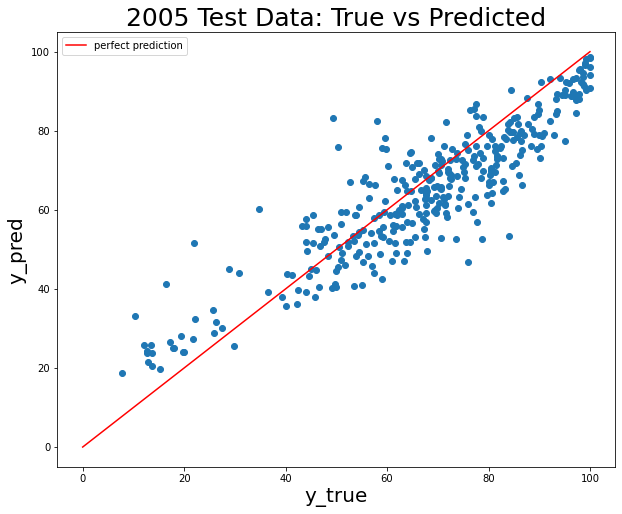

<Figure size 1440x1080 with 0 Axes>

In [41]:
from sklearn.svm import SVR
#SVR FOR GRAPHING PARAMETERS
from sklearn.svm import SVR

def pred_graph_svm_reg(d):
    dates = ['2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        svm_reg = SVR(kernel='rbf', gamma=0.0001220703125, C=128)

        svm_reg.fit(d[date][0], d[date][1].values.ravel())

        y_train_pred = svm_reg.predict(d[date][0])
        y_val_pred = svm_reg.predict(d[date][2])

        train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
        train_r2 = r2_score(d[date][1],y_train_pred)

        val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
        val_r2 = r2_score(d[date][3], y_val_pred)
            
        y_test_pred = svm_reg.predict(d[str(int(date)+1)][2])
        y_test = d[str(int(date)+1)][3]
        plt.figure(figsize=(10,8))
 
        plt.scatter(y_test, y_test_pred)
        plt.plot([0,100], [0,100], c='r', label='perfect prediction')
        plt.title('2005 Test Data: True vs Predicted', fontsize='25')
        
        plt.legend()
        plt.xlabel('y_true', fontsize='20')
        plt.ylabel('y_pred', fontsize='20')
        plt.figure(figsize=(20,15))
        plt.savefig(f"../Figures/true_vs_pred.png", bbox_inches='tight', dpi=600)

        
pred_graph_svm_reg(dictionary)

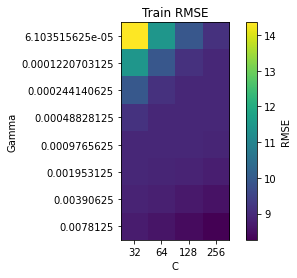

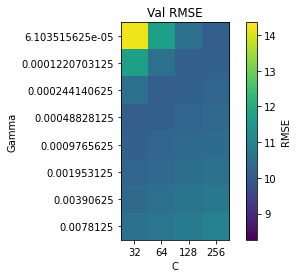

In [42]:
zs = [scores[0] for scores in train_params]

min_score = min(val_params, key = lambda x: x[0])

zs_test = [scores[0] for scores in val_params]

z_grid = [[zs[i*4+j] for j in range(4)] for i in range(8)]
z_grid_test = [[zs_test[i*4+j] for j in range(4)] for i in range(8)]

plt.imshow(z_grid, vmin=np.min(zs), vmax=np.max(zs))

plt.xticks([0,1,2,3],C_vals)
plt.yticks([i for i in range(len(gamma_vals))], gamma_vals) 

plt.title("Train RMSE")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.colorbar(label='RMSE')

plt.show()

plt.imshow(z_grid_test, vmin=np.min(zs), vmax=np.max(zs))

plt.xticks([0,1,2,3],C_vals)
plt.yticks([i for i in range(len(gamma_vals))], gamma_vals) 

plt.title("Val RMSE")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.colorbar(label='RMSE')
plt.show()

In [43]:
def knn_reg(d, n_neighbors, weights):
    dates = ['2002', '2003', '2004']
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for n in n_neighbors: 
            for weight in weights:
                knn_reg = KNeighborsRegressor(n_neighbors=n, weights=weight)

                knn_reg.fit(d[date][0], d[date][1].values.ravel())

                y_train_pred = knn_reg.predict(d[date][0])
                y_val_pred = knn_reg.predict(d[date][2])

                train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                train_r2 = r2_score(d[date][1],y_train_pred)

                val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                val_r2 = r2_score(d[date][3], y_val_pred)

                train_rmse_list.append((train_rmse, n, weight))
                val_rmse_list.append((val_rmse, n, weight))

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min n_neighbors: {min_score[1]}, min weight: {min_score[2]}")
        print(f"  min val rmse: {min_score[0]}")
        
        knn_reg = KNeighborsRegressor(n_neighbors=min_score[1], weights=min_score[2])
        
        knn_reg.fit(d[date][0], d[date][1].values.ravel())

        y_test_pred = knn_reg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)

n_neighbors, weights = [1, 3,10,30,100], ['uniform', 'distance']
        
knn_reg(dictionary,n_neighbors, weights)

2002
  min n_neighbors: 10, min weight: distance
  min val rmse: 10.664408224357585
test rmse:  10.70275714640964
2003
  min n_neighbors: 3, min weight: distance
  min val rmse: 10.84167190852617
test rmse:  12.168211411851514
2004
  min n_neighbors: 10, min weight: distance
  min val rmse: 10.854537217226392
test rmse:  10.030386439961198


In [48]:
def xgb_reg(d, learning_rate, colsample_bytree, subsample):
    dates = ['2002', '2003', '2004']
    scores_best = []
    for date in dates:
        print(date)
        train_rmse_list = []
        val_rmse_list = [] 

        for rate in learning_rate: 
            for n in colsample_bytree:
                for sample in subsample:

                    xgb_reg = xgboost.XGBRegressor(eta=rate, colsample_bytree=n, subsample=sample, seed=11)

                    xgb_reg.fit(d[date][0], d[date][1].values.ravel())

                    y_train_pred = xgb_reg.predict(d[date][0])
                    y_val_pred = xgb_reg.predict(d[date][2])

                    train_rmse = mean_squared_error(d[date][1], y_train_pred,squared = False)
                    train_r2 = r2_score(d[date][1],y_train_pred)

                    val_rmse = mean_squared_error(d[date][3], y_val_pred, squared = False)
                    val_r2 = r2_score(d[date][3], y_val_pred)

                    train_rmse_list.append((train_rmse, rate, n, sample))
                    val_rmse_list.append((val_rmse, rate, n, sample))

        min_score = min(val_rmse_list, key = lambda x: x[0])
        print(f"  min rate: {min_score[1]}, min colsample_bytree: {min_score[2]}, min subsample: {min_score[3]}")
        print(f"  min val rmse: {min_score[0]}")
        scores_best.append(min_score[0])
        
                        
        xgb_reg = xgboost.XGBRegressor(eta=min_score[1], colsample_bytree=min_score[2], subsample=min_score[3], seed=11)

        
        xgb_reg.fit(d[date][0], d[date][1].values.ravel())

        y_test_pred = xgb_reg.predict(d[str(int(date)+1)][2])
        test_rmse = mean_squared_error(d[str(int(date)+1)][3], y_test_pred,squared = False)
        print('test rmse: ', test_rmse)
            
#    print('average score :', np.mean(scores_best[0:4]))

learning_rate = [.2, .4, .6, .8, .9, 1]
n_estimators = [10000]
seed =[0],
missing = [np.nan] 
colsample_bytree = [.2, .4, .6, .8, .9, 1]              
subsample = [.2, .4, .6, .8, .9, 1]
        
xgb_reg(dictionary, learning_rate, colsample_bytree, subsample)

2002
  min rate: 0.2, min colsample_bytree: 0.2, min subsample: 1
  min val rmse: 9.711404862537798
test rmse:  10.327947532286228
2003
  min rate: 0.2, min colsample_bytree: 0.4, min subsample: 1
  min val rmse: 9.771123284079733
test rmse:  10.613217901839626
2004
  min rate: 0.2, min colsample_bytree: 0.8, min subsample: 0.6
  min val rmse: 10.469820233724748
test rmse:  10.699263636268093


In [49]:
#PERMUTATION FEATURE IMPORTANCE
np.random.seed(42)
from sklearn.svm import SVR

d = dictionary
svm_reg = SVR(kernel='rbf', gamma=0.0001220703125, C=128)

svm_reg.fit(d['2004'][0], d['2004'][1].values.ravel())

y_test_pred = svm_reg.predict(d['2005'][2])

df_test = dictionary['2005'][2]
y_test = dictionary['2005'][3]

nr_runs = 10
scores = np.zeros([len(df_test.columns),nr_runs])
baseline = np.mean(y_test)
                  
print('test score RMSE = ',np.sqrt(mean_squared_error(y_test,y_test_pred)))

score_changes = []

for i in range(len(df_test.columns)):
    print('shuffling '+str(df_test.columns[i]))
    rmse_scores = []
    for j in range(nr_runs):
        
        X_test_shuffled = df_test.copy()
        X_test_shuffled[df_test.columns[i]] = np.random.permutation(df_test[df_test.columns[i]].values)
        
        df_test_shuffle = pd.DataFrame(data=X_test_shuffled,columns = df_test.columns)
        
        y_test_shuffle_pred = svm_reg.predict(df_test_shuffle)
    
        rmse_scores.append(np.sqrt(mean_squared_error(y_test,y_test_shuffle_pred)))
        
    print('   shuffled test rmse score:',np.around(np.mean(rmse_scores),3),'+/-',np.around(np.std(rmse_scores),3))

    scores[i] = rmse_scores
    score_changes.append((i, np.around(np.mean(rmse_scores),3)))

important_features_rmse = sorted(score_changes, key = lambda x: x[1])

test score RMSE =  9.440684615695643
shuffling BORO_K
   shuffled test rmse score: 9.434 +/- 0.005
shuffling BORO_M
   shuffled test rmse score: 9.436 +/- 0.004
shuffling BORO_Q
   shuffled test rmse score: 9.442 +/- 0.001
shuffling BORO_R
   shuffled test rmse score: 9.44 +/- 0.001
shuffling BORO_X
   shuffled test rmse score: 9.444 +/- 0.006
shuffling Cohort
   shuffled test rmse score: 9.441 +/- 0.0
shuffling Total Cohort
   shuffled test rmse score: 9.404 +/- 0.021
shuffling Total Grads - n
   shuffled test rmse score: 9.502 +/- 0.012
shuffling Total Grads - % of cohort
   shuffled test rmse score: 12.041 +/- 0.229
shuffling Total Regents - n
   shuffled test rmse score: 9.472 +/- 0.013
shuffling Total Regents - % of cohort
   shuffled test rmse score: 10.334 +/- 0.119
shuffling Total Regents - % of grads
   shuffled test rmse score: 9.543 +/- 0.018
shuffling Advanced Regents - n
   shuffled test rmse score: 9.447 +/- 0.005
shuffling Advanced Regents - % of cohort
   shuffled test 

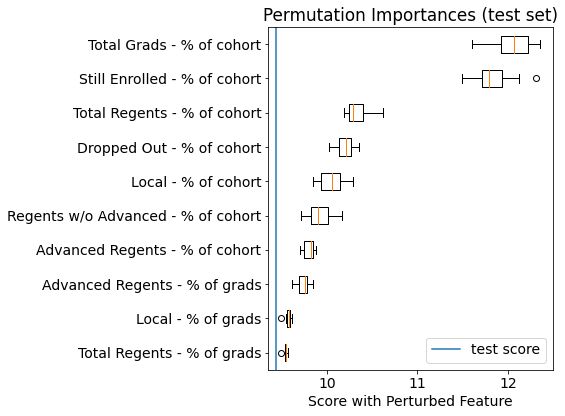

In [50]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[ : :-1][:10]
sorted_indcs = sorted_indcs[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=df_test.columns[sorted_indcs],vert=False)
plt.axvline(np.sqrt(mean_squared_error(y_test,y_test_pred)),label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('Score with Perturbed Feature')
plt.legend()
plt.tight_layout()
plt.savefig(f"../Figures/svr_feature_perm.png", bbox_inches='tight', dpi=600)

plt.show()

In [69]:
# final results for models
data = [['Baseline', 22.056622278712453, 21.350413614292982, 21.8199395053574],
        ['Regression',11.012817331554677, 13.536183328200346, 11.218994724715035], 
        ['Lasso', 9.88089208082889, 10.78090743255249, 9.481728599431532], 
        ['Ridge', 9.869369494947964, 10.50273255128286, 9.562161639539573], 
        ['Elastic net', 9.858229469135654, 10.556346991126958, 9.539393219134638],
        ['Random Forest', 10.151002853252479, 10.756206234334087, 10.474382715946179],
        ['SVR',  9.931287403560146, 10.442639335446241, 9.440684615695643],
        ['K Neighbors', 10.70275714640964, 12.168211411851514, 10.030386439961198],
        ['XGBoost', 10.32794757756723, 10.613217939841592, 10.699263727727063]]
df_models = pd.DataFrame(data, columns=['Model', 2003, 2004, 2005])
df_models['Average'] = df_models[[2003, 2004, 2005]].mean(axis=1)
df_models = df_models.rename(index = df_models['Model']).drop('Model', axis=1)
df_models

,2003,2004,2005,Average
Baseline,22.056622,21.350414,21.819940,21.742325
Regression,11.012817,13.536183,11.218995,11.922665
Lasso,9.880892,10.780907,9.481729,10.047843
Ridge,9.869369,10.502733,9.562162,9.978088
Elastic net,9.858229,10.556347,9.539393,9.984657
Random Forest,10.151003,10.756206,10.474383,10.460531
SVR,9.931287,10.442639,9.440685,9.938204
K Neighbors,10.702757,12.168211,10.030386,10.967118
XGBoost,10.327948,10.613218,10.699264,10.546810


In [79]:
import dataframe_image as dfi
dfi.export(df_models, "../Figures/model_df.png")